Working With Databases
======================

Python works and plays well with many of the most popular relational
databases including PostgreSQL, Oracle and MySQL. The standard library
even has a light-weight product, SQLite, capable of either running in
memory or using the file system for persistent storage.

For this chapter, we’ll work with Python’s **sqlite3** module. It
requires no setup, definition of an administrator, or anything else – it
comes “batteries included”. Also, since it’s part of standard Python you
can rely on it working on any system with Python installed. If you later
choose to use another database – no worries. You’ll need to find and
install a piece of middleware called a “connector” and, of course, the
database software. What you learn here will most apply to the
alternative tools. and your interactions with the objects it provides
will be nearly-identical those you have with **SQLite**. Switching
should be easy.

For the record, here are some popular connectors (which you may
have to install using a package manager if they’re not in your Python
installation).

    MySQL: import mysql.connector
    Oracle: import cx\_Oracle
    PostgreSQL: import psycog3

Basics
------

Let’s get started with importing **sqlite3** and connecting to a
database. If we want to store it on the file system we provide the name
of the file; if we just want it in memory, we can use the special name
“:**memory**”.

In [ ]:
import sqlite3

conn = sqlite3.connect('mydb')
conn

The **connect** object is our gateway into the database. We can access
its methods to change users, commit/roll back changes etc. and otherwise
perform high-level operations at the database level. 

we’ll get a **cursor** object from the **connection** object which we’ll
use for most of our interactions

In [ ]:
curs = conn.cursor()
curs

OK, we’ve got what we need to talk, so let’s have a conversation. The
primary object in a database is a table. A table has rows and columns of
information, and knows about relationships with other tables and their
rows and columns. 

You can create a table using the CREATE keyword,
something like:

In [ ]:
cmd = """CREATE TABLE dogs (name CHAR(10),
         toy CHAR(10),
         weight INT(4))
      """

Here, this command creates a table named ‘dogs.’ It has three columns:
name, toy, and weight. We’ve assigned each column a data type. The
numbers in (parentheses) indicate the size of the data. For instance
‘name’ is specified to hold a maximum of 10 characters.

**SQLite** supports other data types like TINYINT, BLOB, TEXT, and
DOUBLE. You can read more about them in the sqlite.org docs.

Data table names are unique – they have to be. So what happens if we try
to create the table ‘dogs’ and one already exists? **SQLite** will whine
miserably:

    Traceback (most recent call last):
    File "stdin", line 1, in module
    sqlite3.OperationalError: table dogs already exist
    
So, it’s often a good idea to clear the decks first (if you’re sure you
don’t need the table) by going:

In [ ]:
cmd = "DROP TABLE IF EXISTS dogs"
curs.execute(cmd)  # this runs the SQL command

# Create the table again, since we've killed the old one
cmd = """CREATE TABLE dogs (name CHAR(10),
         toy CHAR(10),
         weight INT(4))
      """
curs.execute(cmd)

When we’re done adding the new table, we can ask that the change be
committed by using the connector method **commit**().

    conn.commit() 

Now, let’s populate the kennel. The way to add a row is to use the
INSERT command. The general syntax is:

    INSERT INTO table ( column names) (values)

Here’s an example. We’re telling the database that a 90-pound dog named
Fang has a toy bone:

In [ ]:
cmd = "INSERT INTO dogs ('name', 'toy', 'weight') VALUES (?, ?, ?)"
vals = ('Fang', 'bone', 90)
curs.execute(cmd, vals)

Let’s make sure things are working by retrieving results. To do that you
use the SELECT command. SELECT \* asks for all rows. Generally the
syntax is:

    SELECT * FROM table WHERE some conditions

If you don’t provide a WHERE clause, you get everything, as we do
here:

In [ ]:
cmd = "SELECT * from 'dogs'"
curs.execute(cmd)
print(cmd)

If the database finds rows matching your request, it passes that
information to the cursor object. In order to actually extract data, you
have to ask for it using one of the “fetch” methods which are:
**fetchall**(), **fetchone**(), and **fetchmany**(). 

You need to provide **fetchmany** an integer to let it know how many rows you want.

In [ ]:
result = curs.fetchall()
print(result)

As you can see we get a **list** of **tuples**. If the query didn’t
return anything, we’d get an empty **list**. 

We can now unpack the results using logic like:

    column_1, column_2, column3 = row

In [ ]:
if result:
    print("Congrats, you've got you some dawgs!")
for row in result:
    name, toy, weight = row
    print(name, toy, weight)

Here’s an alternative way to add information using the **executemany**()
method. Note that the first argument is the SQL command and the second
is a **list**-like collection of **tuples** to be executed against it:

In [ ]:
curs.executemany('INSERT INTO dogs VALUES(?,?,?)',
                     (('Biscuit', 'towel', '70'), 
                      ('Snoopy', 'squirrel', '60'),
                      ('Sloopy', 'squirrel', '60'),
                      ('Spooky', 'squirrel', '60'),
                      ('Sparky', 'squirrel', '60'),
                 )
                 )
conn.commit()

cmd = "SELECT * from 'dogs'"
curs.execute(cmd)
result = curs.fetchall()
for row in result:
    name, toy, weight = row
    print(name, toy, weight)

## Database Metadata

We can see that printing these database tables is a tedious business with lots of repeated code.    Below, you'll find a quick-and-dirty routine that might expedite things.   

To make printing a database table more generic, it would be nice to let it be agnostic about the names of the columns, wouldn't it?    We could hard-wire in the names of the columns that we want to print, but every time a column was added or removed we'd have more work to do.

It's possible to query any database for its 'metadata' - that is data about itself.   Each product has a different way to store its own data, but it's easy enough to find out just how to do that.   You can, for instance, query for the names of the database tables, the names and data types of the columns within the tables, relationships between tables, and much more. 

It's also possible to query objects like the cursor to discover the characteristics of its payload.

For instance, if we want to find out the names of the columns of data returned by a SELECT then we can query the description attribute of the cursor:

In [ ]:
print(f"raw cursor description:\n{curs.description}\n")

# If we want a tuple of the column names:
cols = tuple([element[0] for element in curs.description])
cols

In [ ]:
def print_rows(tname):
    "A printing utility function you may want to keep"
    cmd = "SELECT * from {}".format(tname)
    print(f"Running command {cmd}\n")
    curs.execute(cmd)
    cols = tuple([element[0] for element in curs.description])
    result = curs.fetchall()

    if result:
        for r in result:
            nice_output = ''
            for label, res in zip(cols, r):
                nice_output += f"{label:>10} = {res:<10} {'':<2}"
            print(nice_output)

print_rows('dogs')

If we want to know how many rows in the database table we can use
COUNT(\*).

Here's an example:

In [ ]:
cmd = "SELECT COUNT(*) FROM {}".format('dogs')
curs.execute(cmd)

# COUNT only returns one result.  Note the syntax for unpacking a one-element tuple
result = curs.fetchone()
number_of_rows, = result # result[0]

print("Awesome, we've captured {} rows.".format(number_of_rows))

Lazy Evaluation
---------------

The cursor objects fetch methods are “lazily evaluated”. Like **range**
objects and generators, they don’t actually produce information until
requested to do so. This is an awesome feature because, even if your
query returns a million rows, the cursor object has a minimal
“footprint” in memory. 

You can, if you want, iterate through the entire
thing a row at a time using the **fetchone**() method:

In [ ]:
curs.execute('SELECT * FROM dogs')
while True:
    row = curs.fetchone()
    if not row:
        break
    print(row)

One of the implications of all this is that you can’t “rewind” the
cursor – it’s only looking forward. And when they’re done, they’re done
once you’ve run through the catch, if you want another look you’ve got
to execute the query again

Choosing Data with WHERE
------------------------

Often you don’t want all the data available, but only that which meets
certain criteria. 

We can upgrade our SELECT directive to choose only
certain rows and columns.

In [ ]:
cmd = 'SELECT name, weight FROM dogs WHERE weight = 60'
print(cmd)
curs.execute(cmd)
print(curs.fetchall())

If you would prefer that the data be sorted, you can use the ORDER BY
directive.

Note that you can make liberal use of whitespace in a SQL command to maintain your sanity.

In [ ]:
print_rows('dogs')

In [ ]:
cmd = '''
    SELECT
        name, weight
    FROM
        dogs
    WHERE
        weight > 1
    ORDER BY 
         weight, name
    '''
print(cmd)
curs.execute(cmd)
curs.fetchall()

Updating and Deleting Data
--------------------------

To update fields in data already contained in the database, we can use
the UPDATE keyword. The general syntax is:

    UPDATE table SET column value WHERE condition

So, if we wanted Snoopy to put on a bit of weight, we could go something
like:

In [ ]:
cmd = """UPDATE 
            dogs 
         SET 
            weight=666 
         WHERE 
            name='Snoopy'
      """

curs.execute(cmd)
print_rows('dogs')

We can selectively delete data rows using the DELETE command. Its basic
syntax is:

    DELETE FROM table WHERE condition

These examples show how to winnow down our pack of dogs using variants
of DELETE. 

In the first example we’ll delete all rows where the “toy”
column has a specific value. 

Next we’ll use a wildcard to find values vaguely like the toy we’re looking for. 

Finally, we execute DELETE
without any conditions to eliminate all the data, but leaving any
metadata (column specifications, keys, relationships, etc.) intact.

In [ ]:
# Everything
cmd = "SELECT * FROM dogs"
curs.execute(cmd)
print_rows('dogs')

In [ ]:
# Dump dogs with socks
cmd = "DELETE FROM dogs WHERE toy = 'sock'"
curs.execute(cmd)
print_rows('dogs')

In [ ]:
# Apply a wildcard to the select

# %<some str>      <some_str>%
cmd = "DELETE FROM dogs WHERE toy LIKE '%el'"
curs.execute(cmd)
print_rows('dogs')

In [ ]:
# Go nuclear with a general delete (metadata survives)
cmd = "DELETE FROM dogs"
curs.execute(cmd)
print_rows('dogs')

## Database Use In Context

There’s much more to working with databases, naturally, but you now know the basics. And you can integrate them into your apps without having to leave the Python environment.

You'll likely use direct database commands like these and a database like SQLite for on-the-fly, temporary storage of data your program needs to stash.  

If you simply need to pile up a queue of things like web addresses to visit, you can use something like collections.dequeue.  If you want to send interprocess messaging, you can use tools like Celery, Python's xmlrpc library, or Python's asynchio library.

Object-Relational Mapping
-------------------------

If you get serious about working with databases, especially in the
context of a web application, you might look into ORM tools.
Generally, these create Python objects that serve as proxies for actual
database components. They provide an abstraction layer than can keep you
away from the raw SQL code and greatly simplify both your coding task
and maintenance chores.

To give you a flavor of what these beasts have to offer, here’s some
example Django code:

    from django.db import models

    class SnakeId(models.Model):
        id = models.AutoField(unique=True, primary_key=True)
        thumb = models.CharField(max_length=80, blank=True, null=True)
        species = models.CharField(max_length=50, blank=True, null=True)
        img_file = models.CharField(max_length=80, blank=True, null=True)
        r = models.IntegerField(blank=True, null=True)
        b = models.IntegerField(blank=True, null=True)
        g = models.IntegerField(blank=True, null=True)

        def __str__(self):
            return "snake_{}".format(self.id)

        class Meta:
            managed = True
            db_table = 'snake_id'

This code describes a database table, its columns, and some metadata.  Let's break it down:

    class SnakeId(models.Model):
    
This creates a subclass of the models.Model class from Django.   A 'Model' is a database table.

    thumb = models.CharField(max_length=80, blank=True, null=True)
    
Attributes of the Model class are database columns.   The column 'thumb' is an instance of Django's CharField object that stands in for whatever string field your database happens to use.   Under the hood, Django will figure out the exact syntax of the SQL required to communicate with your database.   The 'blank=' and 'null=' bits tell the database and downstream template systems about any restrictions on allowing empty fields.

        class Meta:
            managed = True
            db_table = 'snake_id'
            
In an optional Meta class, you can specify whether Django will take complete control over your database.   If you choose, Django will set relationships among tables, add tables/columns, delete tables/columns, etc. to alter the fundamental structure of your database as your Python-based specifications change.



By using Python objects (and some magic provided by Django) we can do
database queries, pass the query results to a Django HTML template, and
render a complete web page. 

Here's an example:

    from django.shortcuts import render
    
    from .models import SnakeInfo,SnakeColors
    
    def make_view(render)
        snakes = SnakeInfo.objects.order_by('species', 'id')
        
        objs_to_render=[]
        for s in snakes:
            colors=SnakeColors.objects.filter(snake=s.id).
            order_by('-pct')
            objs_to_render.append(colors.all())
            context={'snakes': objs_to_render}
            
    return render(request, 'snakes/index.html', context)
    
    
Here's what's going on:

    snakes = SnakeInfo.objects.order_by('species', 'id')
    
This executes a SELECT command against the **SnakeInfo** table, requesting all rows, and including an ORDER BY clause.    
    for s in snakes:
    
The **for** loop iterates through the returned rows and creates a SELECT statement against a second snake-related table **SnakeColors**, this time using the **id** column as a primary key, and applying a SORT directive.

    return render(request, 'snakes/index.html', context)
    
The **render** directive is sufficient to produce an intact web page using the specified template file and the database query result.    

## Exercise

Please read the data from py_baseball_data.csv. Column names are in the first row. Dates represent no-hitters. Create a new database table and load this data.

Write SQL statements that will let your code figure out how many no-hitters were pitch after June by NL teams.

Write unittests to determine that your code works. 

Hint: you can execute the database creation code in setUp() and destroy the database in tearDown. Individual tests might INSERT or DELETE data and ensure your count stays correct.

Solution: solution_database.ipynb

***********************************************

If you're just getting back ...

... we're working on the exercise in Section 15.8
    above.   I'll check in again at the top of the
    hour.
    
- Pat



************************************************

Logging
=======

Python’s standard library comes with a comprehensive **logging** utility
which is powerful yet easy to use. Logging allows you to get away from
relying on **print**() statements to track the progress of your apps. It
also allows you to selectively choose what to log, and to dynamically
update your choice from within your script.

Basics
------

The easiest way to get logging going is to use the logging module’s
**basicConfig**() method. This tees up essential logging functionality
and produces a **logging**.**logger** that you can access later. 

Let’s begin with a simple example (note - this may require a kernel restart):

In [ ]:
import logging
import os
log_fn = os.path.join(os.getcwd(), "py_log_output.log")
logging.basicConfig(filename=log_fn, level=logging.DEBUG)

logger = logging.getLogger()
# this writes a line to the file
logger.debug("Yup, I'm debugging")
print('logger on')

In [ ]:
# A bonus utility function
def print_file(fn):
    "Reads and prints a text file"
    import os
    if os.path.exists(fn):
        with open(fn) as f:
            for line in f:
                print(line)
    else:
        print(f"Sorry, file {fn} doesn't exist.")

In [ ]:
print_file(log_fn)

Logging Levels
--------------

The logger comes with five logging levels “baked in”. It’s possible to
add custom levels, but these work for most situations.

In [ ]:
import logging

LOG_FILENAME = "py_log_output.log"
LEVELS = {'debug': logging.DEBUG,
          'info': logging.INFO,
          'warning': logging.WARNING,
          'error': logging.ERROR,
          'critical': logging.CRITICAL
          }
logging.basicConfig(filename=LOG_FILENAME, level=LEVELS['debug'])

When we set up the logger, we have gone ahead and set the logging level.  So what do we mean by “logging level”? 

Here’s a way to think about it. When we log an event, we do so with commands like:

    logging.debug(“Some in-the-weeds-information”)
    logging.critical(“Western Civilization As We Know It Is Ending!”)


Unlike the familiar **print** function, these will not necessarily
create a logging event every time the code is run. They will only fire
if they are “worse” than the level we’ve assigned.

Under the hood, the logger assigns “points” to each level:

    logging.DEBUG=10
    logging.INFO=20
    logging.WARNING=30
    logging.ERROR=40
    logging.CRITICAL=50

**logging**.**info**() creates a logging event worth 20 “points”. If the
default level is set to a “point value” less than or equal to that
(DEBUG or INFO) the log event fires.

The idea is that you can sprinkle your code with messages at a variety
of logging levels. During debugging, you might want really verbose
output so you can monitor what’s going on. In production you might only
want to know when the wheels are coming off. If you’re logging network
traffic, you might want to differentiate between (potentially) benign
anomalies and intrusion signatures.

Dynamically Changing the Level
------------------------------

You can change the logging level dynamically by accessing the **logger**
object. Here’s a short app to demonstrate how:

In [ ]:
def shout_out():
    # Cycle through the different built-in levels
    logging.debug("shouting out at debug level")
    logging.info("shouting out at info level")
    logging.warning("shouting out at warning level")
    logging.error("shouting out at error level")
    logging.critical("shouting out at critical level")
    logging.debug("--------")


# log at all levels with level set to DEBUG
shout_out()

In [ ]:
logging.getLogger().setLevel(logging.ERROR)
shout_out()

In [ ]:
def shout_out():
    # Cycle through the different built-in levels
    logging.debug("shouting out at debug level")
    logging.info("shouting out at info level")
    logging.warning("shouting out at warning level")
    logging.error("shouting out at error level")
    logging.critical("shouting out at critical level")
    logging.debug("--------")


# log at all levels with level set to DEBUG
shout_out()

logging.getLogger().setLevel(logging.ERROR)
shout_out()

# Reset to DEBUG
logging.getLogger().setLevel(logging.DEBUG)

print_file(log_fn)

Customizing Your Logging
------------------------

You’re not stuck with the default levels. Internally, the system knows
the “point value” for all these, but you can assign your own.

Let’s say that you have identified a situation that raises a
WombatException. You might decide that its criticality is something
between WARNING and ERROR and want to adjust accordingly. 

You can
create a logging message by grabbing an instance of the logger and
utilize its **getlogger**() method, something like

    class WombatException(Exception):
        logger=logging.getLogger()
        logger.log(WOMBAT, "Wombat!")

You can also customize what your logging message looks like, borrowing
system object like the name of the module, the name of the function, and
time of day. You can do this as part of the **basicConfig**() setup by
going something like:


    logging.basicConfig(filename=LOG_FILENAME,
    level=logging.DEBUG, format=LOG_FORMAT)

The LOG\_FORMAT is sort of like the format string that you’d feed to
**str**.**format**(). The main difference is that you can tap into
predefined “wildcard” characters that are associated with system-level
information like the module name, time of day, function name, etc.

A format string defined thusly:


LOG_FORMAT = "%(asctime)s called from %(module)s: %(lineno)d %(message)s"




… will produce a message like this one:

|                                                            |
|------------------------------------------------------------|
| 2016-10-04 08:31:55,113 called from py\_log\_3: 11 Wombat! |

Here are some of the more commonly-used format string options:

    %(asctime)s default: 2003-07-08 16:49:45
    %(created)f time created
    %(filename)s filename only
    %(pathname)s full path
    %(funcName)s function called from
    %(levelname)s level (DEBUG, etc.)
    %(levelno)s level (10, etc.)
    %(lineno)d line number
    %(module)s module name
    %(message)s message
    %(name)s logger name


You can find a complete listing of them in the official docs at https://docs.python.org/3/library/logging.html#logrecord-attributes.

Here’s how one might implement a logger with a custom level, which might
be triggered in the event of a real Wombat emergency.

In [ ]:
import logging

# Logging constants
WOMBAT = logging.WARNING + 1
LOG_FILENAME = "py_log_output.log"
LOG_FORMAT = "%(asctime)s called from %(module)s: %(lineno)d %(message)s"

# Logging setup
logging.basicConfig(filename=LOG_FILENAME,
                    level=logging.DEBUG,
                    format=LOG_FORMAT)

# Custom exception


class WombatException(Exception):
    logger = logging.getLogger()
    logger.log(WOMBAT, "Wombat!")

# Raise the alarm!


def do_raise_wombat():
    raise WombatException

demo_mode = False
if demo_mode:
    raise_wombat()

In [ ]:
print_file(log_fn)

Logging to Multiple Destinations
--------------------------------

You might find yourself needing to separate logging traffic into
something like a “log of record” which records every bit of minutia.
Maybe you’re cataloguing all the IP traffic on a site and hanging onto
it for a week for potential forensic analysis. Vital stuff, but not
intended for humans. You might want to have, in addition, a way to send
only critical messages to human responders – maybe via a text message or
phone call. Python’s **logging** library can handle that, too.

**Logger** objects are endowed with “handlers” which manage the traffic
from the logging system. Each logger can have multiple handlers, which
can be configured separately. The default, which we’ve implicitly been
using, is a **FileHandler**. As you’ve seen, it dutifully updates a
designated log file with each event.

Let’s say we want to send only critical messages to the console and log
all messages in a file. 
Here’s how we might set up an extra handler for
the critical messages:

In [ ]:
# Adapted from docs/python.org/howto/logging-cookbook.html
import logging

LOG_FILENAME = "py_log_output.log"

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(name)-12s %(levelname)-8s’ ‘%(message)s',
    datefmt='%m-%d %H:%M',
    filename=LOG_FILENAME)

# Create a new Handler
console = logging.StreamHandler()
console.setLevel(logging.ERROR)

# Create a new Formatter
formatter = logging.Formatter('%(name)-12s: %(levelname)-8s %(message)s')

# Install the Formatter in the Handler (just like tk widgets)
console.setFormatter(formatter)

# Install the Handler in the Logger
logging.getLogger('').addHandler(console)

# Let's try it out.
logging.critical('Wombats have been detected!')
logging.debug('just more boring log content')

In [ ]:
print_file(LOG_FILENAME)

Another new wrinkle in this demo is the use of a time format. If the
string “%(asctime)s” appears as part of the **logging**.**Formatter**
specification, the system produces a **datetime** object. As such, you
can use any of the normal **datetime** format strings with it.  Cf. https://strftime.org/
Here, we’ve specified our choice with the “datefmt” keyword provided to
**basicConfig.**

Several “flavors” of handlers are available for different tasks. The
**SocketHandler** will stream log output across a network (perhaps to a
remote database). **SMTPHandler** can be used to send critical text
message or email assuming, of course, you’ve got the capabilities set up
already. The different “Rotating” handlers help manage large volumes of
log traffic by archiving old files as necessary. 

The details are beyond
the scope of this class, but here’s a list, for your reference.

|                          |                   |
|--------------------------|-------------------|
| FileHandler              | SysLogHandler     |
| StreamHandler            | DatagramHandler   |
| NullHandler              | NTEventLogHandler |
| WatchedFileHandler       | SMTPHandler       |
| BaseRotatingHandler      | MemoryHandler     |
| RotatingFileHandler      | HTTPHandler       |
| TimedRotatingFileHandler | QueueHandler      |
| SocketHandler            | QueueListener     |

## Exercise

The file py_log_english_brewery_data.csv is a text file containing all the breweries and their counties reported by Wikipedia. https://en.wikipedia.org/wiki/List_of_breweries_in_England
Please create an app that:

- De-duplicates the list


- Identifies those with “Ale” in their name


- Stores them in a database with (beer, is_ale, county) columns


- Log the key events as your app steps through the process.

Solution:  solution_logging.ipynb

Extra credit:


- Provides a simple GUI that lets users search the database for “Ale”/”non-Ale” breweries, and by county (they can type it in).

Solution:  solution_logging_gui.ipynb

Introduction to NumPy
======================================

For real number-crunching Python offers the **numpy** library which
includes all sorts of optimized array operations, and integrates well
with other components of Python’s scientific stack\[63\].

When working with **numpy**, you have to sacrifice some of the
convenience of objects like **lists** and work with clearly-defined,
single-type objects (as is the case when working with the **array**
library). **numPy** is strongly typed – you have to declare everything
as **float**, **int**, or some other C-type. It is not optimized for
non-numeric types like strings.

But if you’re serious about data, **numpy** is the right tool. It’s a
very thin Python API (application program interface) written on top of
compiled byte-code – which makes it blazing fast. It also has quite a
bit of statistical and array manipulation capability baked right in, so
is “one stop shopping” for most garden-variety projects (and some
serious ones too).

NumPy forms the basis of virtually every statistical application in the Python ecosystem.   For many applications, you'll never have to access it directly.  Pandas, for instance, has objects built directly onto numpy that are much easier to use.   But most objects use the ndarray as a base class, retaining all the characteristics of ndarrays.

## ndarrays

The ndarray is the main object in the numpy library.  As the name applies, it can contain an arbitrary n-dimensional data structure.

In [ ]:
import numpy as np
arr = np.array([1, 2, 3])
arr

In [ ]:
type(arr)

## Constructors

If you don't want to use one of the default instantiation methods, you
can create a home-made array directly from a **list** of tuples. A
**tuple** of lists, **tuple** of tuples, and **list** of lists also
work. Here's how you might whistle up a 2-D array - as you can see, the
**ndarray** object represents itself as an 'array', presenting its
contents like a **list** of lists would.

Note:  If you know how big your array will be, it's best to use a constructor to create a placeholder, then fill it.

Under the hood, memory will be allocated only once.

In [ ]:
d = np.array([(0, 1, 2, 3), (10, 11, 12, 13), (20, 21, 22, 23)])
d

In [ ]:
d.dtype

In [ ]:
print(f"Shape: {d.shape}  Dimensions: {d.ndim}")

You can just provide the dimensions.  Note the content will be garbage values close to zero.

In [ ]:
array_2d = np.ndarray((2, 3))
array_2d

In [ ]:
print(f"Shape: {array_2d.shape}  Dimensions: {array_2d.ndim}")

In [ ]:
array_2d.dtype

Alternatively, you can create arrays pre-populated with default values:

In [ ]:
shape = (2, 3)

print('ones')
print(np.ones(shape))
print()

print('zeros')
print(np.zeros((2, 3)))
print()

print('empty')
print(np.empty(shape))
print()

print('default values')
shape = (3, 3)
default_val = 5.0
dtype = 'int'
print(np.full(shape, default_val, dtype=dtype))
print()

print("identity")
print(np.eye(3, dtype=np.int32))

If you want random numbers you can use one of the methods from the **np.random** library.

This produces a 3x2 matrix of random numbers between 0 and 1:

In [ ]:
np.random.rand(3, 2)

As you can see, a **numpy** array is not an **array**.**array** object
or anything we’ve seen before. It is its own dog. Let’s chat it up a
bit. The shape here is a **tuple** with a single element showing us the
number of elements in its first (and only) dimension. 

You can use
indexing and slicing operations, just as you would a **list** object:

In [ ]:
# The shape is a tuple, one element for each dimension, showing elements in that dimension
arr.shape

In [ ]:
arr

In [ ]:
arr[-1]

In [ ]:
arr[1:3]

Let’s make it more interesting and add another dimension. 

Notice that we can define it with the same syntax we used to compose a **list** of lists:

In [ ]:
# This constructor literally uses a list of lists.  There are others.

arr2d = np.array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]
                  ])

arr2d

In [ ]:
# We have two dimensions with three elements in each.
arr2d.shape

In [ ]:
arr2d[:   , 1]

In [ ]:
[complex(x, x+1) for x in range(4)]

Numpy can also create an array from any sort of iterable object.   Here, we'll use a list comprehension to whistle up some complex numbers to do the job

In [ ]:
np.fromiter([complex(x, x+1) for x in range(4)], dtype=complex)

## NumPy File Operations

NumPy arrays can be created directly from a file (another form of a constructor).  They can also be written to files.

Here's an example:

In [ ]:
# Create an ndarray containing only integers.
dtype = np.dtype('int8, float, int')
d = np.array([(6, 3, 8), (20, 1, 80), (4, 3, 34)], dtype=dtype)
print(d)
# Write it to the file system.
fn = 'junk.npy'
d.tofile(fn)

Note that we specified the data type with a **np.dtype** object created
on the first line. More on data types later, but for now just know that
we have to clue NumPy in on what shape and element types we'll be
passing back and forth to the file system. 

If we don't, the default
behavior is to save the data in a flattened format that we'd have to
reshape once imported. 

In [ ]:
# Retrieve the file as an array
new_d = np.fromfile(fn, dtype=dtype)
new_d

Here's how we can make sure nothing got lost in transit.  Note that the '==' operator works in an element-wise fashion, comparing each array element pairwise, and coming up with a True/False call for each:

In [ ]:
d == new_d

So to check whether every comparision is True (each element is the same) we need to use the ndarray's **all()** method.  Note the parentheses.

Also note that there's also an **any** method.

In [ ]:
result = (d == new_d).any()
print(f"Are they equal?  {result}")

print(f"Are the same shape? {d.shape == new_d.shape}")

We could also save the array as a binary file (the default behavior is
to use Python-specific pickles). Building on the previous array
definition, and using the **save**() and **load**() methods:

In [ ]:
np.save(fn, d)
del d  # just to prove it works
d = np.load(fn)

Data Types
----------

### Built-in Numeric Data Types 

NumPy provides a great selection of numeric data types ( **'dtypes'**)
that work with **ndarrays**. These include signed and unsigned integers
(**int** / **uint**), floating point (**float**) and complex
(**complex**) numbers. Integers can be specified in widths ranging from
8 to 64 bytes, floats from 16 to 64, and complex as either 64 or
128. These are named **float14**, **uint8**, etc.

NumPy arrays can contain all sorts of different types of data. The only
rule is that an array can contain only one type – and this is so each
element is constrained to be the same size for computational efficiency.
The type can be any of the built-in **dtypes** e.g., **uint64** or
**complex32**.

### Custom Data Types

It's also possible to "roll your own" data structures – and they can be
heterogenous in terms of the object types they contain. 

For instance,
you can create a dtype consisting of a string, a complex number, a
float, and an integer so:

In [ ]:
dtype = '|S4, c8, float16, int32'
data = ("hello", complex(1, 2), 4.3, 6)
g = np.array(data, dtype=dtype)
g

Also,
you'll notice that the string 'hello' got truncated to 'hell' – that
because it was pruned to fit the specification. You'll note that this
happened silently.

You need to be careful in this regard. If the extra wide string you
store gets truncated it may not be a big deal. But if you try to store
too large a number, what gets stored can be really strange. You may
want to see what happens on your machine, but when I try to store the
number 10,000,000,000 as a 32-byte integer, the number that actually
gets stored is 1,410,065,408. 

Silently. Yikes.


### **Object** Data Type

It's possible to get around this issue by getting a little vague about
the dtype specification by using **object** as the type. You might think
this violates the notion that all the elements in an **ndarray** have to
be the same size. But it doesn't because internally the **ndarray** is
storing a reference only, and the reference can point to just about
anything.

In [ ]:
h = np.array([("hello", 23), ('goodby', 45)], dtype='object, int32')
h

If you look carefully at this last example, you'll see that the array
can be specified fairly compactly. 

The data can be provided as a
**list** of tuples and the **dtype** can be specified all in a single
command. Also, the string representation of the dtype consists of a
**tuple** for each object – 'f0' and 'f1' are internal field name labels
and the 'O' and 'i4' stand in for 'object' and the 4-byte integer.

Here's an important performance note: if you create an array of objects,
you'll likely give up some of **NumPy's** blazing-fast performance. 

Why?
Because you're creating list-like objects where the "stride length" –
the amount of memory required for each element in the array – is no
longer sufficient to extract the data. 

A second step is imposed – the
pointer to the object only gets us to the starting point of the
contents, and the amount of memory allocated to the object needs to be
discovered before the actual contents can be accessed.

In [ ]:
d = np.array([(0, 1, 2, 3), (10, 11, 12, 13), (20, 21, 22, 23)])
d

Slicing and Indexing
--------------------

The number of elements in the shape **tuple** lets us know that the
array has a "**rank**" of 2 – that's the number of dimensions, and the
same as the number of axes. Alternatively, we could ask about the
dimensions directly by querying the **ndim** property. The output
reveals that the first axis provides an **index** over 3 **elements;**
and the second provides an index over 4 elements.

We can address parts of the array by using slicing operations, just as
we did with the 1-D array. The only difference is that you can (but
don't need to) address each dimension ("**axis**") independently. Here's
how you can get a specific row and a specific element. By providing a
single argument, we address the first axis of the array (the "row").

## A Note on Precision

For all its charm, **NumPy** arrays, being dependent on the hardware's
floating point operations and its implementation of the underlying C
libraries, generally can't offer more than 64-bit precision. This being
said, it is possible to create a **ndarray** of **object** type
(elements serve as pointers only) and use objects like
**fractions**.**Fraction** and **decimal**.**Decimal**.

In [ ]:
fractions.Fraction (1, 3) --> (2, 3)

In [ ]:
d

In [ ]:
row = d[1]
row

In [ ]:
element = d[1][1]
element

Let's examine this exchange. We can see that the result is an object
with a single axis. If we provide a double index, we can extract a
single element. The single element is no longer an array, but is
whatever **dtype** numpy chose as a default (it'll take a guess based on
the type of objects passed in via the constructor).

We can get a little fancier, if we want, and extract an element (of
block of elements) with a more complex slice based on specifications
against both axes. The only difference is that we need to provide two
slices, separated by a comma. The second slice, naturally, operates on
the second axis - the "columns". 

Here are some examples:

In [ ]:
arr2d = np.array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]
                  ])

arr2d

In [ ]:
col = arr2d[:, 1]
col

In [ ]:
top_left_chunk = arr2d[:2, 0:3]
top_left_chunk

In [ ]:
bottom_corner = arr2d[-1, -1]
bottom_corner

In [ ]:
stg = "wertqwer"
stg.upper().title().startswith("w")

In [ ]:
skip_cols = arr2d[:, ::2]
skip_cols

In [ ]:
type(skip_cols)

There are a couple things to note with this exchange. First, the object
returned (unless it's a single element) is always an **ndarray**.
Second, the object returned as a column represents itself the same way
as the object returned as a row – potentially a bit confusing at first.

As with lists, these arrays also work and play well with **slice**
objects. These can enhance the transparency and maintainability of your
code because you can use them anywhere a slice specification is
appropriate. For instance you could replace the top\_left\_chunk
definition with the following and achieve the same result:

In [ ]:
row_slice = slice(0, 2)
col_slice = slice(0, 3)
top_left_chunk = arr2d[row_slice, col_slice]
top_left_chunk

## Copies and Views

There's another similarity between lists and **ndarrays** – if you use
the "=" operator, you don't make a fresh copy of the array. You simply
give a second name to the same object. 

To make a real, "**deep copy**" you can either use the **copy**() method:

In [ ]:
e = d
id(e) == id(d)

This goes much further. Remember the "top\_left\_chunk" and "col" arrays
we just created? They aren't new objects, either – instead they are
still "joined at the hip" to the original array – technically they are
"**views**" of the original. An operation on any of them is reflected in
the original. 

Check this out:

In [ ]:
print(f"Our array 'd' is:\n\n{d}")

col = d[:, 1]
print(f"\nOur column 'col' is:\n\n{col}")

In [ ]:
print("We can change our column:\n")
col[1] = 777
col

In [ ]:
print(f"Our array 'd' is:\n\n{d}")

print(f"\nThe array 'e' is also changed:\n\n{e}")

To avoid this, we can make a new object with a copy() operation.   That "burns the bridge" between the two objects.

Here, we do the hard copy, then change 'd' back, and 'e' will keep its present value:

In [ ]:
e = d.copy()
col[1] = 11

print(f"Our array 'd' is:\n\n{d}")
print(f"\nThe array 'e' is intact:\n\n{e}")

Under the hood, the system has allocated a chunk of memory for the
original object. 

That same memory can be shared by one or more other
objects – that's the "view" idea. Because the memory is shared,
operations on any object that references that memory changes the state
of the memory for all other objects. 

It's something to watch out for,
particularly if you're going to need to expand or shrink the array later
on. By default some operations have built-in checks for multiple references, but they can throw some non-intuitive
errors and can be overridden.

Note that because we now have two dimensions, we need to separate the
slicing operation on the first dimension from the operation on the
second with a comma.

       arr2d[<slice of first dimension>, <slice of second dimension>]

We can extract a row by naming it in the first dimension and choosing everything in the second:

In [ ]:
print(f"original:\n{arr2d}\n")

second_row = arr2d[1, :]
second_row

We can extract a column in the same way:

In [ ]:
print(f"original:\n{arr2d}\n")

second_col = arr2d[:, 1]
second_col

Working With NumPy Objects
==========================

## High-Dimensions




### Thinking in high dimensions

Numpy ndarrays are capable of handling an arbitrary number of dimensions.

That does not mean people do so well.   3-D is OK for most people because that's the world we live in.   Add a 4th dimension - call it 'time' maybe - and most can handle it.   After that ... all bets are off.

One way to think about high dimensions is in terms of a "feature
set" – how many things describe the object. 

We could consider physical characteristics of an object to be features - each with its own dimension.

For a coin we might consider denomination, date, condition, where
produced, nationality, shape, exterior ridges, etc. 

All could be
considered dimensions and represented as axes in an **ndarray** object.

### Coding In high dimensions

All operations discussed here extend into high-dimension objects – some,
like slicing, are just a bit more complicated to think through and
implement. Here are a few examples that you can use for practice. The
first bit builds a stack of 2-D arrays. The top values are 3.xx, mid
values are 2.xx and bottom values are 1.xx – just to make it easy to
"eyeball" the results. 

There's no need to study the code below
extensively – its main purpose is to show how you can build a
dimensionally-complex array from smaller ones:

In [ ]:
def make_box():

    # Make a multi-celled container (think Rubrik's cube) from three layers.
    top = np.empty((3, 3))
    mid = np.empty((3, 3))
    btm = np.empty((3, 3))

    # Fill the cells with numbers that "label" each layer
    for arr, val in zip((top, mid, btm), (3, 2, 1)):
        for row in range(arr.shape[0]):
            for col in range(arr.shape[1]):
                arr[row, col] = np.random.random() + val

    box = np.array((top, mid, btm))

    return box


box = make_box()
box

In [ ]:
# Middle layer
box[1]

In [ ]:
# Middle layer, middle row
box[1, 1, :]

In [ ]:
# Middle layer, middle row, middle element
box[1, 1, 1]

## Element-wise Operations

**Numpy** array math is really easy because the operators work
“element-wise” i.e., on the entire array, all at once. 

Some examples:

In [ ]:
arr2d

In [ ]:
print(f"original:\n{arr2d}\n")

arr2d * 2

In [ ]:
# NB:  Operations create new objects.  The original is unchanged.  If you want to replace the original you need to #be explicit, something like this will work:
#
#   arr2d = arr2d * 2

print(f"original:\n{arr2d}\n")

In [ ]:
print(f"original:\n{arr2d}\n")

arr2d**2

In [ ]:
arr2d

You can also do some operation to a slice of an array, then combine the
results with the original. 

Here’s how you might double the values of a
single row. 


In [ ]:
print(f"original:\n{arr2d}\n")

arr2d[1, ] = arr2d[1, ] * 2  # double values of second row.
arr2d

In [ ]:
print(f"original:\n{arr2d}\n")

arr2d.T  # transposition (switch rows and cols)

Other operations like +, -, and / all  perform calculations element-wise over the entire data structure.

NB:  The * operator does element-wise multiplication.  The ndarray.dot() method does real matrix multiplication when applied between matrices.   The ndarray.dot() method calculates the dot product when applied between vectors.


## Basic Statistical Info

You can also perform analysis on all the elements to gather statistics.
Here’s how, you can get the minimum, maximum, and other values.

In [ ]:
# Built-in methods

print(f"sum: {arr2d.sum()}")
print(f"mean: {arr2d.mean()}")
print(f"min: {arr2d.min()}")
print(f"max: {arr2d.max()}")
print(f"standard deviation: {arr2d.std()}")

In [ ]:
# Borrowing from scipy to generate column-wise stats

from scipy import stats
st = stats.describe(arr2d)
print(st)
print(f"\nmin:  {st.minmax[0]}")

In [ ]:
st.minmax

In [ ]:
# Borrowing from pandas to get nice stats (works best in 1 or 2d)

import pandas as pd
pd.DataFrame(arr2d).describe()

In [ ]:
arr2d

## Data Masks


Along the same lines, here’s how you might use vectors to create a
“mask” to extract the diagonal elements:
    
     row_mask=np.array([0,1,2])
     col_mask=np.array([0,1,2])
     
These vector-wise masks can be applied against the two dimensions thusly:

     arr2d[row_mask, col_mask]
     
... so the first row_mask element and the first col_mask element (0,0) get paired up to select an element of arr2d.  Then (1,1) and (2,2) get paired up.   The result is extraction of the diagonal.


In [ ]:
print(f"original:\n{arr2d}\n")

row_mask = np.array([0, 1, 2])
col_mask = np.array([0, 1, 2])
arr2d[row_mask, col_mask]

In [ ]:
# We can verify this against the built-in diagonal() method:
arr2d.diagonal()

You create what’s called a “Boolean index” – basically a logical
operation run against each element of the array. 

For instance, if you
wanted to get the even numbers, you could go:

In [ ]:
print(f"original:\n{arr2d}\n")

bool_index = arr2d % 2 == 0
bool_index

You can now use the multiplication operator to “mask out” the odd
numbers. You could do that in situ, “zeroing out” the odd numbers, or
extract them into a new array using the mask as an index operator.

Element-wise multiplication takes care of the whole thing:

In [ ]:
print(f"original:\n{arr2d}\n")

arr2d * bool_index

Numpy also has several methods in the **numpy.ma** library to support
these operations. A common use case is to "weed out" values that would
otherwise goof up a calculation. 

Here's an example using the
**masked\_array**() method against an array containing a null **np.nan**
value:

In [ ]:
np.nan  #NaN

In [ ]:
g = np.array([1, np.nan, 3])
g

This is problematic because Numpy isn't clever enough to do a mean calculation with a null value.

In [ ]:
g.mean()

One way to handle it is to get rid of the null value using **np.ma.masked_array()**:

In [ ]:
np.ma.masked_array(g, [False, True, False]).mean()

Shape Shifting
--------------

NumPy supports methods to change the shape of an array. 

In [ ]:
d = np.array([[1,   2,  3,  4],
              [5,   6,  7,  8],
              [9,  10, 11, 12],
              ])

d

In [ ]:
d.shape

For instance if
you want to "vectorize" an array i.e., make a 1-D object from higher
dimension one, you can use the **ravel**() method. 

In [ ]:
e = d.ravel()
e

In [ ]:
e.shape

If you want to make a version of a flattened array that you can iterate over, you can use **np.flatiter()**:

In [ ]:
iter_version = d.flat
iter_version

In [ ]:
next(iter_version)

In [ ]:
e

The opposite operation can be accomplished with the **reshape**()
method. The idea is that you can specify the shape of a new object by
providing a **tuple**.

Of course, you don't need to restore the orginal shape.

The only rule is that you need to account for
each element in the original – in other words if the operation were
Musical Chairs, everyone would get a seat when the song stops.
Otherwise, you'll get a **ValueError**. 

For instance we could change the
original object with shape (3, 4) to a new one with four rows by
specifying a new shape (4, 3) like so:

In [ ]:
e.reshape(4, 3)

It's possible to resize an array. For instance, we can use the
**numpy.resize**() method to reduce the array we just created to a shape
of (2,2). This will redistribute as many elements of the original that
are required into the new object. 

This elements are chosen row-wise –
taking the elements in the same order as provided with the **ravel**()
method.

In [ ]:
e = np.resize(e, (2, 2))
e

We can also expand the size of the array. If we use **numpy.resize**()
again to make it larger, the elements of the original array are
distributed throughout the new array getting "recycled" as necessary.

In [ ]:
e = np.resize(e, (4, 4))
e

If we use the array method **resize**() – not the numpy method - the
newly-created elements will default to zeros. 

This is an in place
operation so there's no need to assign the result to a new object (in
fact it returns **None**).

In [ ]:
k = np.array([(1, 2, 3)])
k

In [ ]:
k.resize((3, 3), refcheck=False)
k

Note that we provided a keyword parameter via 'refcheck = False'.   Numpy is a bit of a 'nanny state' in this regard.  If we try to do something potentially dangerous to our data, it will issue a warning. 

## Scalar Products

As seen earlier, scalar products can be obtained simply by using the * operator.

Here's an example:

In [ ]:
print(f"original:\n{arr2d}\n")

arr2d * 4

Dot products (inherently between vectors) can be calculated with the dot() operator.  It's both a method of numpy and the ndarray.

Here's an example:

In [ ]:
vector1 = np.array([9, 10])
vector2 = np.array([2, 3])

print(f"vector1: {vector1}")
print(f"vector2: {vector2}")

np.dot(vector1, vector2)   # same as vector1.dot(vector2)

In [ ]:
np.dot(vector1, vector2)

## Matrix Products

Matrix products (inherently between matrices) can also be calculated with the dot operator.  

In matrix mulitplication, we simply 'dot' the rows and columns.

                     [ 13  9  7 ]        
    [ 3 4 2]  np.dot [  8  7  4 ]   =  [ 3*13+4*8+2*6  3*9+4*7+2*4  3*7+4*4+2*0 ]  = [ 83  63  37 ]
                     [  6  4  0 ]
                     
    [ 2 0 ]          [ 1 2 ]        =  [ 2*1+0*3    2*2_0*4 ] = [ 2 4 ]
    [ 1 2 ]          [ 3 4 ]           [ 1*1+2*3    1*2+2*4 ]   [ 7 10]

Check this out:

In [ ]:
a_arr = np.array([3, 4, 2]).T   # transposition creates a column vector
b_arr = np.array([[13, 9, 7], [8, 7, 4], [6, 4, 0]])

print(f"a_arr:  \n{a_arr}\n")
print(f"b_arr:  \n{b_arr}")

np.dot(a_arr, b_arr)

In [ ]:
c_arr = np.array([[2, 0], [1, 2]])
d_arr = np.array([[1, 2], [3, 4]])

print(f"c_arr:  \n{c_arr}\n")
print(f"d_arr:  \n{d_arr}")

np.dot(c_arr, d_arr)

## Example:  Calculating Covariance

Using Numpy's data manipulation tools, it's straightforward to calculate a covariance matrix.

A covariance matrix provides the covariance between matched pair of elements. 

Covariance is a measure on how much closely high values of one variable correlate with high values of the other variable, and low values of one variable correlate with low variable of the other.   

If high values of one variable go along with high values of the other and vice-versa, the covariance would approach 1.0.  If high values of one variable to with low values of the other, the covariance would approach -1.0.   If there's no relationship whatsoever, the covariance would be 0.

More formally, covariance is the expected value (or mean) of the product of their deviations from their individual expected values.   For two variables X and Y:

    covariance(X,Y) = E [  (X - E(X)) * (Y - E(Y)  ]

The covariance of a variable with itself is the variance:

    covariance(X,X) = E [ ( X - E(X)) ]
    
Variance is a measure of dispersion, or "spread" of a variable's distribution.

In [ ]:
# Calculate covariance between two arrays.

# Setting a seed is optional, but if you provide a seed the random numbers are the same
#    every time you run a script with random calculations.  Note that this ensures that
#    the same sequence of random numbers will be generated from the time that the
#    seed() method is called.   If you are just experimenting, you might want the same
#    first number for each experiment.  In that case, you'll call seed() repeatedly.

SEED = 1
np.random.seed(SEED)

# Create vectors of values drawn from a normal distribution

# Parameters of the normal distribution
means_of_x_and_y = [10, 10]
cov_of_x_and_y = np.array([[3, 1],      # var(X)   cov(X,Y)
                           [1, 5]])     # cov(X,Y) var(Y)
samples = 30

# Create a matrix of values drawn from a normal distribution
np.random.seed(1)
x = np.random.multivariate_normal(means_of_x_and_y, cov_of_x_and_y, samples)


# For each element, calculate difference between it and column mean.
axis = 0  # Designates the 'column' axis
u = x - x.mean(axis)

# Calculate the sample covariance (N-1 instead of N in demoninator)
cov = np.dot(u.T, u)/(samples-1)

# Eyeball the result
print(f"Handmade covariance:\n{cov}\n")

# Check against Numpy's cov() function
np_cov = np.cov(x.T)
print(f"Numpy covariance:\n{np_cov}\n")

# Check each element
print("Element-wise check:")
truth_table = cov == np_cov
print(truth_table)

# Check the whole enchilada
print("Checking for all True:\n")
print(truth_table.all())

## NumPy-specific Help

Because Numpy is so complicated, it has several built-in ways to get help.

    numpy.lookfor():   does a keyword search over docstrings.
    numpy.info():      works like help() except one can provide a string to get multiple results
    numpy.source():    returns the source code for any Python object (not the C code, though)


Numpy has built-in universal functions known as **ufuncs**.  Here's how to get help on them:

In [ ]:
from numpy import doc
help(doc.ufuncs)

In [ ]:
help(np.random.multivariate_normal)

A Real-World Application
------------------------

I have a special interest in Pythons. So much so that I’m trying to help
get rid of Burmese Pythons and have designed a trap to do just that.
With software written in Python, of course, and using **numpy** and
Python’s image processing library **PIL**.

Below, you’ll find some code to do chromatic reduction, pixel-wise on
images of pythons within the trap.  How it actually works is beyond the scope of this course, but you may find it interesting.

The take-away here is that much can be accomplished with a few lines of code by bouncing a digitized image back and forth between an image library and numpy's number-crunching abilities.

To demonstrate, we'll assume we've caught a yellow-ish python in a black trap and snapped a glamour shot.   Our immediate goal is to remove the background.

We begin by loading PIL (Python Image Lirary) and Numpy.   

We'll open an image file and convert it to RGBA format:

In [ ]:
"""a snake-charming application"""
from PIL import Image
import numpy as np
import os

# Set up some handles to info we'll use later
idir = os.getcwd()
saveas = 'new_snake.PNG'
image_name = './img_ds/media/snake_black.JPG'

Here's the image in it's original JPG format:

In [ ]:

raw_image = Image.open(image_name)
raw_image

The converted image doesn't look any different - it's just a different format that we can work with.

In [ ]:
converted_image = raw_image.convert('RGBA')
converted_image

In [ ]:


# Use PIL.Image to open the image and convert it to RGBA



# Show the image in a modal window.
raw_image

There are several color models out there.  CMYK (cyan, magenta, yellow, black) is used for printing solid colors on media.  RGB and RGBA (red, green, blue, alpha) are used to create colors with light, as we do with computer monitors.  

HSV (hue, saturation, value) and HSL (hue, saturation, lightness) allso used with solid colors and are useful in computer vision applications because proximate values appear to be close to the same color.

Here we use the RGBA model because the channels are nicely discretized and map will into a data structure.   

The RGBA version of our image is a 2-d array (width * height) or 4-element tuples.

Here is how we might specify some colors and map them to the RGBA model:

In [ ]:
# Create some ndarrays to characterize colors
white = np.array([255, 255, 255, 0])  # r, g, b, a
black = np.array([0, 0, 0, 1])
blue = np.array([0, 0, 255, 255])
orange = np.array([255, 128, 0, 255])

Now we can use the symmetry between the analytical, digitized version and the Image library's conversions to manipulate the image and display it.

In [ ]:
# Get some image metadata

converted_colors = converted_image.getcolors(w*h)

# Dump the data into a numpy array and split the channels "bands"
data = np.array(converted_image)  # h * w * 4 array (rgba)
r, g, b, a = data.T

background = black

# Use masking condition and replaces the background color (& is boolean 'and')
replace = (r == background[0]) & \
          (b == background[1]) & \
          (g == background[2])

data[replace.T] = tuple(orange)

# Generate a new image
new_image = Image.fromarray(data, 'RGBA')

new_image.show()

We can now tweak the image - perhaps the background isn't really black, but it's close:

In [ ]:
THRESHOLD = 50

data = np.array(converted_image)  # h * w * 4 array (rgba)
r, g, b, a = data.T

# Relax the criteria if needed (or even apply fuzzy logic)
replace = (r <= THRESHOLD) &\
          (b <= THRESHOLD) &\
          (g <= THRESHOLD)

data[replace.T] = tuple(orange)

# Generate a new image
new_image = Image.fromarray(data, 'RGBA')
new_image.show()

## Exercise

To celeberate completion of this class, you might have a party for your computer-oriented friends. 

Let's say you stock up with three 12-packs of great beer:

Beer 1: IPA 

Beer 2: Lagar 

Beer 3: Stout 

Each 12-pack has three rows of bottles (call them 1, 2, and 3) and four "columns" of bottles (call them 1, 2, 3) as well.  You stack three racks of beer on top of each other in three layers.
    
    111 112 113 114    IPAs
    121 122 123 124
    131 132 133 134

    211 212 213 214    Lagers
    221 222 223 224
    231 232 233 234

    311 312 313 314    Stouts
    321 322 323 324
    331 332 333 334
   
Can you find a way to create a single numpy array looks just like this?    

    Each array element will have a value of: (100 * beer value) + (10 * row value) + (1 * column value).

Now, practice your slicing skills and see if you can strip out these chunks of the array: 

- only IPA


- the middle two elements, of each of the bottom two rows of the Lagar portion: 222 223 232 233 


- This middle row of the Stouts: 321 322 323 324 


Solution:   solution_numpy_array_slicing.ipynb

Overview of Data Visualization / Presentation Tools
---------------------------------------------------

### Introduction to Matplotlib and Seaborne

Matplotlib is the visualization tool that's integrated into Numpy and
pandas. It provides several "out of the box" plotting tools along with
the ability to customize new charts and graphs through its API. Seaborne
wraps Matplotlib and provides a suite of high-level, aggregate
visualization tools. 

While this course is not focused on visualization,
the current chapter will provide you enough background to spin up basic
graphics and generally interact with the API.

Enough to be dangerous,anyway ;-)



### Working With Matplotlib

While working with Matplotlib can considerably more tedious than
whistling up a chart with Excel or Open Office, the beauty is that it's
tightly integrated with the other tools you'll be using. Over time,
you'll build up an inventory of reusable objects/code to fit your needs
to a tee.

Fret not, however, because rudimentary graphics are ridiculously easy to
produce. Here's a simple example:

 Overview of Pandas
==================

Pandas (the term is derived from "panel" and "data”) is a data analysis
framework developed by Wes McKinney in 2012 (he remains the
BDFL). Built primarily on the NumPy **ndarray** object, it is
particularly strong in handling date and time series because it provides
high-level wrappers around Python's built-in **datetime** objects.
Visualization based on Matplotlib is also knit into the main pandas
objects. 

This chapter explores some of the more useful features of the
pandas library.

Working With Pandas in an IDE
-----------------------------

The pandas library is fairly complex. It provides a variety of data
structures and tools for manipulating sequences, two-dimensional tables,
and three dimensional data panels. Due to its complexity, and that of
the underlying **ndarray** objects, you may find an IDE valuable as you
explore new objects and learn how to manipulate them.

Over time, however, you may find that the GUI is more of a hindrance
than an asset. There is quite a bit of overhead involved – not only to
support the visual aspects, but in managing several threads/processes
and having to push all the information through the sockets managed by
the IDE software. As your data sets grow larger, performance will become
a real issue. Besides, you'll likely be running your code on remote
servers which won't be configured for GUIs.

Fortunately, Python has several tools for text-only debugging in the
standard library. 

For this course, we'll focus on examples written against the REPL or
Jupyter notebooks for clarity of exposition.

Enhancements from ndarray Objects
---------------------------------

The pandas library contains some really useful enhancements to NumPy
arrays. 

### Indexing

The principal advances are around indexing – pandas provides
extremely flexible means of providing **datetime** and **str** indices
on its objects while NumPy uses only integers.

One of the implications is that the index objects have a separate
existence from the objects they are associated with. It's possible, as
we'll see later, to "stretch" an index value. For example, if we have
weekly data originally using "weeks" as it's index we can reconstitute
the index as "days" then reassign it. Before conducting operations on
the array, its values will be aligned to the new index.

### Missing Data
Another important enhancement is that pandas objects handle missing data
smoothly – much as SPSS or SAS does. This is important when dealing with
"stretched" indices, for instance, when the now-unoccupied index points
receive placeholder values. The nice thing is that the placeholders are
evaluated just as you would hope when used for calculations. If you ask
for the mean of a NumPy array with a single **numpy.NaN** value, the
mean is reported as numpy.NaN. With pandas, the value simply drops out
of the equation and the mean is reported as average of the remaining
values.

### Categorical Data

Pandas also supports easy ways to "bin" values into buckets of
user-definable ranges. This, in turn, allows creation of pivot tables
and operations on categorized data. They also provide native support for
database-like queries on data **Series** objects – no need to build an
actual database or resort to "roll your own" means of selecting and
organizing your information.

### Object Compatibility

Finally, since pandas are built on NumPy / SciPy, methods from these
libraries can be applied to pandas data structures. Nothing has been
left behind.

Naturally, all of this comes at a performance cost relative to working
with "straight up" **ndarrays**. A homogenous **ndarray** is
computationally efficient and the tools used to manipulate it are thin
wrappers around compiled C libraries. Wickedly fast. 

Pandas objects are
a bit further away from the "bare metal" – in particular the requirement
to consistently realign arrays to their indices requires a
potentially-costly computational step every time the array is loaded.

Series Objects
--------------

The **Series** object might be regarded as a chimeric combination of a
**list**, a **dict**, and a database. It contains indexable elements,
which can be looked up with keys, and selected / sorted as one might do
with a database query.

### Creating a Series

Here's a simple way to create a **Series**:

In [ ]:
import pandas as pd

data = [10, 20, 30, 40]
ser = pd.Series(data=data)

ser
type(ser)

To provide data, all we need to do is pass along an iterable object and
**Series** takes over from there. As you can see, we get an index "for
free" and the default is the same as for a **list** object – consecutive
integers beginning with 0. **Series** even chose an appropriate data
type (**int64**). Had we provided a **list** of **float** types the
elements would be type **float64.**

### Addressing Elements

We can work with it much as we would a **list**. For instance,
**Series** objects support slicing. They also accept heterogeneous
members. Note that as we add elements, the data type automatically
adapts and now is **object**.

In [ ]:
ser[0] = 'some string'
ser[1] = (1, 2, 3)

ser

### Managing Elements

Adding and removing elements works pretty much like operating on a
**dict**. For instance, we can add a new element to a non-contiguous
index point. We can simultaneously remove and capture a value using the
**pop**() method. 

As is the case with a **dict**, the **get**() method
is a little more robust because it accepts a default value to be
returned in case the index doesn't exist (it's spared the trouble of
producing a **KeyError**).

In [ ]:
value_3 = ser.pop(3)
value_3

In [ ]:
ser

In [ ]:
ser.get(666, 'nope')

In [ ]:
ser

If you ever want to have a look at the index or the values, you can use
methods by the same name to return **Series**-like objects. If you want
to convert either to a **list**, you can use the **tolist**() method:

In [ ]:
print(ser.values.__repr__())

ser.index.tolist()

### Searching

We can also conduct searches on both the members' values and the
**Series** index. To search for the presence of an index value,
simply use the Python keyword **in**. 

To search values, we use
the **isin()** method. 

The latter produces a "Boolean mask" – an object
the same shape as the target, populated with **True** or **False**
indicating presence or absence of the searched-for object in that
location:

In [ ]:
2 in ser

666 in ser

In [ ]:
ser.isin([(1, 2, 3), 30, 50])

Note that the search terms can be arbitrarily numerous. The only rule is
that they need to be provided as some **list**-like object – even if
it's only one element. 

Both of these work:

In [ ]:
ser.isin([0,])

In [ ]:
ser.isin((1,))  # a one-element tuple

To replace all the values in a **Series** with a new values, you can use
the **replace**() method. For instance, if we had an instrument
measuring absolute temperature (Kelvin), we can be pretty sure that zero
is a bad reading. The instrument probably was off line. 

We can do an
inplace substitution of the bad reading with a NaN like so:

In [ ]:
from numpy import nan

ser = pd.Series([100, 110, 0, 115])
ser.replace(0, nan, inplace=True)
ser

In [ ]:
len(ser)

### Managing Indices

The **Series** object comes with a default index, as we've seen. It's
possible to upgrade it by providing a new one. The only rules are that
there has to be an index value for each element of the **Series**, and
the value has to be immutable (just like a **dict**).

In [ ]:
p = [1,2,4]
p[0]

In [ ]:
data = [10, 20, 30, 40]
ser = pd.Series(data=data)
ser.index

In [ ]:
ser.index = ('dog', 'cat', 'bear', 'anteater')
ser.index

We can now use the upgraded index to pick off individual elements.

Alternatively, we can still get to them by using the index value if we
provide it using the **iloc()** ("index locator") method.

In [ ]:
ser['dog']

In [ ]:
ser.iloc[0]

In [ ]:
ser.plot(kind='bar')

We'll do much more with the **Series** object as we explore
**DataFrame**s in the next section.

## Exercise
Carbonify, an Australian nonprofit, maintains climate change information on its website: 
http://www.carbonify.com/carbon-dioxide-levels.htm.  Included is atmospheric CO2 saturation levels from the Mauna
Loa Observatory in parts per million. Obeservations were taken in April of each year 1958-2017.


The data is available to you as a list in 'mauna_loa_co2_starter_notebook.ipynb'.


Please use your new knowledge to:

- create a Series object from the list and apply an index to reflect the timeframe over which the data was collected;


- replace any obviously bad values with a np.NaN object;


- use the Series.mean() method and slicing operations to figure out the average CO2 saturations for the first 10 years and the last 10 years of data then print them out;


- create a histogram of the cleaned-up data.

Solution:  mauna_loa_co2.ipynb

Pandas in 2-D
-------------

**Series** object provide convenient containers for simple data like a
company's stock's price over time. More often than not, we'll be
interested in bundling several data streams, such as the stock prices of
all companies in an industry. Further, we'll likely be interested in
comparing contemporaneous prices and will be using using time as the
common 'unit of analysis'. Pandas provides an object that's very
well-suited to this task, the **DataFrame**.

This section provides an overview of the **DataFrame** and its basic
operations.

### The DataFrame

The **DataFrame** object contains two dimensions of data. It's
convenient to think of it as a spreadsheet or a database table. In fact,
it has many of the characteristics of both. It's really a stack of
**Series** objects (the ‘columns’). 

The stack can be indexed and
addressed just as the **Series** objects are. 

Additionally, the
**DataFrame** contains powerful methods for reading, writing, reshaping,
combining, and otherwise manipulating data. Let's explore using a
tangible example.

### Creating an Instance

One way to create a **DataFrame** is to provide an iterable object. In
the example below, we'll use a **dict** object – this allows us to pass
in index values for both "rows" and "columns".

In [ ]:
data = {'c1': pd.Series([11, 21, 31], index=['r1', 'r2', 'r3']),
        'c2': pd.Series([12, 22, 32], index=['r1', 'r2', 'r3']),
        'c3': pd.Series([13, 23, 33], index=['r1', 'r2', 'r3']),
        }
df = pd.DataFrame(data)
df

### Addressing Rows, Columns, and Elements

By inspection, we can see that each **Series** object entered as a
column in the 2-D table. If we want to extract a column, we can simply
use its index value. To obtain an individual element, we can "double
index" it, just as we can with an **ndarray**. 

There are a few ways to
accomplish these tasks:

In [ ]:
# Get a column
df['c2']  # alternative: df.iloc[1]

In [ ]:
# Get a row
df.iloc[-1]  # alternative: df.loc['r3']

In [ ]:
# A single element
df['c2']['r2']  # alternatives: df.at['r2', 'c2']); df.iat[1, 1])

In [ ]:
# Alternative methods
df['c2']['r2'] == df.at['r2', 'c2'] == df.iat[1, 1]

### Scalar Operations

**Series** and **DataFrame** objects support the same scalar
(element-wise) operations as **ndarrays**. 

Here are a couple examples:

In [ ]:
df/10

In [ ]:
df['c1']*100

It's easy enough to add a column and apply a scalar operation using the
**assign**() method. This code calculates a new column's values, assigns
a new column index, and returns a 'scratch copy' of the original – all
in one fell swoop. 


In [ ]:
df.assign(c4=df['c2']/10)


Note that the original is unchanged – we could simply
reassign the name 'df' to the copy if we wanted to make the change
permanent.

In [ ]:
df

### Insertions and Deletions

Observe that in the last example we didn't provide quotes around the
name of the new column – that happens automatically "under the hood". If
this isn't the desired behavior, you can insert a column "manually" with
the same syntax as adding a **dict** entry:

In [ ]:
df['c4'] = df['c2']
df

To get rid of the new column we can use the system-level **del**
command, just as with a **dict** object:

In [ ]:
del df['c4']
df

We can also insert columns using the **insert**() method. The general
syntax is a bit different than that of **assign**():

    df.insert ( insertion point (col number) , new index,  name , new data )

In [ ]:
# We can find the index value of a named column.
col_index = df.columns.get_loc('c1')
print(
    f"The DataFrame.columns.get_loc() method says col 'c1' is at index {col_index}.\n")

# Here, we create and label a new Series.
new_col = pd.Series(data=[666, 777, 888], index=('r1', 'r2', 'r3'))
print(f"Our new column is: \n{new_col}.\n\n")

# Use the insert() method to inject a new column.
df.insert(loc=col_index, column="new", value=new_col)
df

There are a few of things to note here.

-   The col\_index needs to be the integer value of the insertion point
    – this can be retrieved with the **get\_loc()** method of the
    **columns** object.
    

-   **insert**() is an in-place operation. We didn't need to go: "df =
    df.insert..." to make the changes permanent.
    

-   Since we provided row index values 'r1', 'r2', etc. earlier, we need
    to include them here, as well. If we don't, the element values will
    (silently) enter the **DataFrame** as **np.NaN**. 
    

Here's an example
    using a "bad" row index value:

In [ ]:
# Create a Series with an index value 'xxx'
new_col = pd.Series(data=[666, 777, 888], index=('r1', 'r2', 'xxx'))
print(f"Our new column is: \n{new_col}.\n\n")

# Use DataFrame.insert() to poke in a new column.
df.insert(loc=col_index, column="new1", value=new_col)
df

If you want to add a row, a simple way to is to simply add a
non-existing one using the **loc**() method. 

It has the effect of expanding the array and adding the new data.

In [ ]:
# Let's start with some fresh data:

data = {'c1': pd.Series([11, 21, 31], index=['r1', 'r2', 'r3']),
        'c2': pd.Series([12, 22, 32], index=['r1', 'r2', 'r3']),
        'c3': pd.Series([13, 23, 33], index=['r1', 'r2', 'r3']),
        }
df = pd.DataFrame(data)
df

In [ ]:
# Define our new row as a tuple.  Pandas will figure out what to do.
row_data = (41, 42, 43)

# Use the DataFrame.loc() method to add the row.
df.loc['r4'] = row_data
df

**Note:** that this isn't necessarily the most efficient way to expand an
array. Much better if you can know *a priori* how big it will eventually
be and can create a sufficiently-large empty one. Operations like this
need to create new object, find memory for it, move existing content,
then add the new data. All this can get expensive – especially for large
data sets.



To delete a row, you can tap the **index** attribute. 

This example drops the last row:

In [ ]:
df = df.drop(df.index[-1])
df

### Introspecting Indices

If you ever need to discover the rows and columns, you can do so with
the **index** and **columns** attributes. 

These will both produce an
**Index** object (useful if you want to recycle the **index** for use in
a new object – you can simply assign it to the new object's **index**
attribute). 

Note that you can use "cherry pick" the rows returned by
enumerating them. You can slice the columns for the same effect. 

If you
want a straight up list, you can use the **tolist**() method.

In [ ]:
rows = df.iloc[[0, 2]].index.tolist()
rows

In [ ]:
cols = df.columns.tolist()
cols

In [ ]:
cols = df.columns[0:2].tolist()
cols

OK. You've now got a pretty good repertoire of skills working with
**DataFrame** and **Series** objects. As you may have noticed these
objects have a lot in common in terms of how to address elements and
methods available to manipulate them. Please take a crack at the
following exercises and test these skills out.

## Exercise
The Python machine learning library Scikit-Learn comes with several practice datasets. You can get to the Tenenhaus exercise and fitness database thusly:

    >>> import sklearn.datasets as ds
    >>> everything = ds.load_linnerud()

The result, called 'everything' here, is a "bunch class". That's a class where all the objects are available via a dict-like object.

    >>> everything.keys()
    dict_keys(['target', 'data', 'DESCR', 'target_names', 'feature_names'])

This object is a nice package of the description of the data sets and column names (data/feature_names and target/target_names). The data is already in ndarray format.

    >>> type(everything['data'])    
    class 'numpy.ndarray'
    
Most (if not all) of the practice datasets in the sklearn.datasets package are bundled in this fashion.


Please work this data to:

- Create a DataFrame for each of the target and data objects


- Add the columns of the target DataFrame to the data DataFrame


- The data database accounts for the situps, chinups, and jumping jacks each respondent performed. Add a new column to serve as an "exercise index": 

    3 * chinups + 2 * situps + jumping jacks.


- The target database accounts for subjects' weight (lbs), waist (inches), and pulse (bpm). We'll want more civilized units for future analysis. Please convert the weight column to kg (2.2 lb = 1 kg) and waist column to cm (1 in = 2.54 cm).

Solution:  solution_exercise.ipynb

Pandas in 3-D
-------------

**Pandas** supports creating 3-D structures by stacking **DataFrame**
objects – much as **DataFrame**s are essentially stacked **Series**
objects. Individual **DataFrames** can be accessed by a third index
variable. One way to conceptualize these 3-D objects is from their
original intent – to serve as containers for panel data. You might have
presidential approval survey data that displays answers (columns) by
respondent (rows) that is collected each month so the "**Panel**" of
respondents is tracked over time as the political winds blow. Time
serves as the additional dimension.

 Data Acquisition
================

Numpy (and pandas) support tons of easy ways to create data structures
directly or upon importing data from files, web pages, etc. They also
support some powerful ways to examine, clean, and manipulate data once
acquired. We'll discuss these here.

The main methods are found in the ../pandas/io library and reading for
text-like files is found in the module **parsers.py**. The latter is
worth a quick look if you want to understand what's going on "under the
hood" – important if you want to know about what the various arguments
work, what the defaults are, how inferences about things like file types
are managed, how duplicate columns are handled, etc. This chapter will
discuss some of the more common data acquisition tools and introduce you
to the rest.

### CSV Files

CSV[19] is a common format for passing data files around because it's
light-weight and (nearly) machine/application independent. Pandas'
method to handle these, **read\_csv()** extends the standard **csv**
library by adding some additional parsing options and translators to
create intact **DataFrame** and other objects.

Let's get started by providing a small \*.csv file and printing its
contents:

In [ ]:
fn = 'test_data.csv'

with open(fn, 'w+') as f:
    f.writelines(["c1, c2, c3\n",
                  "11, 12, 13\n",
                  "21, 22, 23\n"]
                 )
    f.seek(0)

    for line in f.readlines():
        print(line[:-2])

Now, we can sic the **read\_csv**() method on it thusly:

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv(fn)
df

In [ ]:
print(f"We have a: {type(df)}\n")
print(f"With a shape:  {df.shape}")
df.dtypes

You can see that this method has done a lot of heavy lifting. It handled
the file open, close, and read operations. The first line was inferred
to contain the column index values. The elements were correctly inferred
to be integers. And it created a 2 row by 3 column **DataFrame** object
with the appropriate indices and variable types without being asked. Not
bad for one line of code!

Naturally, we can override any of this default behavior. For instance,
if we want to bring the data in as 16-byte floating point numbers, we
could add the appropriate keyword argument:

In [ ]:
df = pd.read_csv(fn, dtype=np.float16)
df.dtypes

The keyword overrides are extensive and (mostly) self-explanatory.
Here's a list of them. The actual default values for things like **sep**
(a comma) and the documentation for the rest of these can be found in
the **TextParser**() method of **parsers.py**

|                           |                          |                                 |
|---------------------------|--------------------------|---------------------------------|
| sep = sep                 | delimiter = None         | header = 'infer'                
| names = None              | index\_col = None        | usecols = None                  |
| squeeze = False           | prefix = None            | mangle\_dupe\_cols = True       |
| dtype = None              | engine = None            | converters = None               |
| true\_values = None       | false\_values = None     | skipinitialspace = False        |
| skiprows = None           | nrows = None             | na\_values = None               |
| keep\_default\_na = True  | na\_filter = True        | verbose = False                 |
| skip\_blank\_lines = True | parse\_dates = False     | infer\_datetime\_format = False |
| keep\_date\_col = False   | date\_parser = None      | dayfirst = False                |
| iterator = False          | chunksize = None         | compression = 'infer'           |
| thousands = None          | decimal = b'.'           | lineterminator = None           |
| quotechar = '"'           | quoting = 0              | escapechar = None               |
| comment = None            | encoding = None          | dialect = None                  |
| tupleize\_cols = False    | error\_bad\_lines = True | warn\_bad\_lines = True         |
| skipfooter = 0            | skip\_footer = 0         | doublequote = True              |
| delim\_whitespace = False | as\_recarray = False     | compact\_ints = False           |
| use\_unsigned = False     | low\_memory = True       | buffer\_lines = None            |
| memory\_map = False       | float\_precision = None  |                                 |

Some of the non-intuitive, but potentially useful, of these include:

**date\_parser** - you can include a function to handle this if your
format is weird;

**squeeze** – forces a **Series** instead of a **DataFrame** if there's
only one column;

**infer\_datetime\_format** – applies the first **datetime** string
found to parse all others;

**header** = None – overrides automatic grabbing first row as column
headers;

**usecols** – takes a **list** of the columns you want to pull into your
new object.

The **read\_csv**() method can be used on many types of files – even
compressed ones. It groks the compression method using the file name. So
it's smart enough to know to run **gzip.GzipFile** against \*.gzip
files, **bz2** against \*.bz2 files, etc.

### Spreadsheets

Use the **pd.read\_excel**() method to read spreadsheet-like files. This
also works on URLs (local file:\\\\... or those served up over the
Internet "http:\\\\..."). There are lots of options that you can specify
with keyword arguments just like **read\_csv**(). You can call
**help**() to get a full listing. We'll discuss some of these here.

**sheetname** - The default is 0, which grabs the first (zero-indexed)
"tab" and returns a **DataFrame** object. Set it to some other integer
to grab a different one. Specify **None** to return a **dict** with each
"tab" in its own **DataFrame**. Alternatively, you can provide a name
like "Sheet1". To get several "tabs" as a **dict** of **DataFrames**,
specify a **list** of the ones you want. \[2, 5, "mySheet"\] will work
just fine.

**header** – The default is 0 meaning that the first row is the column
header. You can override this to use a different row. Specify **None**
if your data has no header row. Similarly, **index\_col** is used to
specify the column to be used as row labels.

**parse\_cols** – you can pick what columns to pull into your
**DataFrame**. The default, **None**, grabs all the columns. You can
specify a **list** of the column numbers (zero indexed) or a string. The
string can contain individual columns or ranges – "A, F, G:H" will work.

A couple of examples:

    df = pd.read_excel(filename, usecols = "A:M")
    df = pd.read_excel(filename, usecols = [1,3,5])

### Databases

Pandas has several methods for reading database table contents, and even
executing SQL queries, then transforming the "take" into a **DataFrame**
object.

The **read\_sql\_table**() method takes a table name and a connection
object. The latter will be a live connection to a specific database,
already authenticated with the user name, password, etc. as required.
The connection object needs to be SQLAlchemy – the **sqlite** connector
will not work.

The **read\_sql\_query**() method is a little more flexible. You provide
a SQL string containing your SELECT statement and a connection object.
This method has maximum power when using a **SQLAlchemy** connector, but
will work with a **sqlite** connector as well.

**read\_sql**() works pretty much like the other two methods – in fact
it serves as a wrapper around both, selecting the appropriate one based
on the connector type. The main difference is that if you use a
**DBAPI2** connector object, it will ONLY read **sqlite** tables. If you
use a **SQLAlchemy** connection, any other database is supported.

## BigQuery

There is also an experimental method to execute commands against Google
BigQuery[20] r**ead\_bgq()**. This requires authentication into Google
using OAuth 2.0 using the appropriate key.

## Data Chunking

All these methods allow you to choose which columns to haul into your
**DataFrame** object with the **columns** keyword (which works the same
as the spreadsheet and csv methods). Additionally, they have a
**parse\_dates** option where you can provide a **list** or **dict** of
columns to be parsed into **datetime** objects – this is valuable if the
dates appear as strings in the target database. Finally, they have a
**chunksize** option for use with really big databases. This creates an
iterator that will pull in so many rows at a time so you don't bring
your system to its knees by trying to take the whole database into
memory at once.

## HTML Tables

You can, optionally, create pandas objects straight from a web site
using **read\_html**(). You feed it a URL-like string for an HTTP, FTP,
or file URL page (not "secure" versions like HTTPS) and it will return a
**list** of **DataFrame** objects, one for each table encountered. This,
too, has lots of keyword options. See the docs and/or read
..pandas/io/html/py for the gritty details.

A few of the more useful keywords:

> **match** – a regex used to figure out which tables to parse. The
> default is ".+" (grab everything), but that's probably not what you
> want to do.
>
> **flavor** – this is the parsing engine to use. The default is
> **lxml**. If that fails it uses **html5lib** (Beautiful Soup) as a
> "secondary default".
>
> **attrs** – this is a **dict** to help identify the table you want to
> use. The keys are valid HTML table attributes e.g., "id"

Be aware that parsing web pages is a dicey business. While a parsing
engine will do its level best, it can be thwarted by poorly-written HTML
(missing tags, etc.), inconsistent use of id tags, strange encodings,
etc. "Trust, but verify".


## Serialized Objects

Pandas can produce **DataFrame** objects from a variety of serialized
formats. Available methods include:

**read\_json**() – reads JSON files

**read\_msgpack**() – reads msgpack (sort of a "JSON lite" format) files

**read\_pickle**() – reads the Python-specific pickle format

**read\_hdf**() – reads HDF-5 files (efficient storage of homogenous
data arrays)

## Other Formats

Pandas supports creation of **DataFrames** from a few other formats.
These methods are similar to the others discussed so I'll just mention
them here.

**read\_strata**() - for Strata (similar to SAS/SPSS) files

**read\_sas**() – reads XPORTed SAS files or those formatted as SAS7BDAT

**read\_table**() – use this for general delimited file, similar to
read\_csv()

**read\_fwf**() – use this for fixed-width formatted files.

As you can see, you have tons of built-in ways to acquire data for your
analysis. You'll likely not ever need to "roll your own" data gathering
tools if you can master the relevant libraries. Have fun!


Dealing with Missing Data And Outliers
--------------------------------------

In the real world, data sets are often messy. Some of the "mess" is due
to missing data – a weather instrument may be out of order, a respondent
skipped a question, etc. Sometimes it's due to data that's all over the
map – due either to real randomness or things like an electrical spike
in the weather instrument or a respondent misunderstanding the question.
Whatever the cause, it's often necessary to tidy up a data set before
analyzing it – and in the process better understand its "texture and
color".

This section will show you some of the ways you can preprocess a raw
dataset using native Python tools. In the process, I'll show you some
embedded ways to whistle up pandas objects and populate them with data
with straight Python code.

## A Quick Tip - Start Simple

Here's a tip: when exploring new methods or objects in pandas, you may
want to start with synthetic and/or well-understood data. 

We've seen
examples of using syntetetic data with playing with the **DataFrame**
object – this helps you make sure the operations are working as you
intend before using them to explore data sets you don't (yet)
understand.

##  Missing Data

Missing data is a fact of life in the real world. It's flagged in
various ways. For instance you might find "NA", "n/a", etc. in text
data. Sometimes it will be encoded in agreed-upon values e.g., missing
weather data from the NWS often appears as -999. Missing column values
from a spreadsheet might appear as NULL. Here are a few ways to handle
it in Python.

Consider the following code:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Produce a Series
total_observed = 100
s = pd.Series(np.random.choice([10, 20, 30, 40, -9], total_observed))

# Print some diagnostics
print('count: {} missing: {}'.format(s.count(),
                                     total_observed-s.count()))

# Make a quick and dirty histogram
h = s.hist()

Here, we've created a **Series** object using the **np.random.choice**()
method (this wraps the standard Python random library). This will take
the values provided in an iterable and produce a **Series** with
**total\_observed** elements, each chosen randomly from iterable's
elements. The -9 stands in for an encoded missing value.


To get rid of the missing values we can tap the **replace**() method of
the **Series** object. It works just like the **str** method. 

Here, we
take advantage that pandas (via NumPy) has a special placeholder for
missing data, **np.nan**. This placeholder is cool because it
magically drops out of calculations like means, standard deviations, and
counts.

The optional keyword **inplace** = **True** means a new object
will not be created as a result of the operation and that **None** will
be returned. 

Check this out:

In [ ]:
s.replace(-9, np.nan, inplace=True)  # <-- inplace=True
h = s.hist()

print('count: {} missing: {}'.format(s.count(),
                                     total_observed-s.count()))

When it's run, the missing values are replaced by the **np.nan** object,
rendered as "NaN". 

Note that the **count**() method reflects the length
of the **Series** sans the missing data. 

If you want to scrub the NaN values completely, you can use the
**dropna**() method. 

This, too, has an optional **inplace** keyword
option. If you choose not to use it, you'll need to use the assignment
operator '=' to make the changes "stick".

In [ ]:
# Start with a fresh Series
s = pd.Series([10, np.nan, 20, np.nan])

print(f"Original series:\n\n{s}\n")

In [ ]:
# Create a new object
new_s = s.dropna()  # no inplace = True

# ... or do the inplace operation:
s.dropna(inplace=True)

print(f"New series:\n\n{s}\n")

Note that the output reflects that the index values associated with the
missing data have disappeared (the original data is associated with the
original indices). The length of the **Series** reflects the removal of
the NaNs.

If you simply want to extract null values, you can use use the
**isnull**() method

If you want the valid values, you can
use the **np**.**notnull**() method.

In [ ]:
# Start with a fresh Series
s = pd.Series([10, np.nan, 20, np.nan])

s.isnull()   # The opposite is notnull()

You can use NaN (or any other criteria) to make a mask.   A way to make a series out of the non-null values is to use the results of the null test the same way as a slice:

In [ ]:
s[s.notnull()]

## Replacing Missing Values

Sometimes you want to replace missing values with reasonable estimates
of what the data probably is. For instance, if you are looking at hourly
temperatures and have gaps, you have a pretty good idea that the missing
values are going to be between the good observations. Pandas has some
ways to handle this situation. 

To illustrate, let's generate a clean
**Series** with some NaN values sprinkled in:

In [ ]:
s = pd.Series([100, np.nan, np.nan, np.nan, 200])
print(s)

If we want, we can give the null values a specific new value using
**np.fillna**(). 

We'll make a deep copy of the original and try it out:

In [ ]:
t = s.copy()
t = t.fillna("Zilch!")
t

We can get a little fancier and pick one of the bracketing good values
to serve as the new value. 

The **ffill**() method takes the previous
valid data point and projects it "forward".

In [ ]:
t = s.copy()
t = t.fillna(method='ffill')
t

The opposite method, **bfill**() takes the next good value as the
replacement. For this example, we'll also use the **limit** keyword
argument – this limits the number of consecutive missing values to be
replaced (works for **ffill**() as well). 

You might want to set this to
a reasonable number such that really big gaps are apparent when you run
quality checks, and that estimated values don't span such large gaps
that they become bogus.

In [ ]:
t = s.copy()
# <--- gaps larger than 2 are not auto-filled
t = t.fillna(method='bfill', limit=2)
t

Often times, you'll want to get a bit fancier and calculate interpolated
values. Again pandas comes to the rescue with the cleverly-named
**interpolate**() method. 

Here is its basic usage.

In [ ]:
t = s.copy()
t = t.interpolate()
t

The **interpolate**() method has lots of options. 

As with **ffill**()
and **bfill**() we can tell it whether to project new values forward or
backwards, and set a limit as to the number of consecutive null values
to be replaced. 

It also supports different "flavors" of interpolation
(as you can see from the results, the default is linear) – and that's
where the direction of the projection can become material.

In [ ]:
t = pd.Series([100, 120, np.nan, np.nan, np.nan, 200])

t = t.interpolate(method='quadratic', direction='backward')
t

You'll note that we had to give the **Series** another good value to
support the quadratic extrapolation method.

The interpolation options include **cubic**, **polynomial**, **nearest**
(picks the most proximate good value), etc. If you want to explore all
of the options, you may want check out the docs:

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html#pandas.Series.interpolate.

## Outliers

Sometimes your data will contain elements that simply cannot be valid.
Let's say your relative humidity monitoring equipment suddenly says
"200" – a physically impossible metric. You would want to throw that
data point out before doing any analysis. Or let's say you're measuring
outdoor temperatures on a winter day and get sporadic readings in the
120 degree (F) range. This is pretty suspect and probably indicates an
instrumentation error.

Or let's say you're measuring things like rainfall and baseball
statistics and learn that in 2016 Houston got 50" of rain in a week
eight months after the Cubs won the World Series. This can't be correct.

Ummm. The point is that you should scrub outliers carefully and with
plenty of reflective thought. 

Anyway, here are a couple of ways to
handle them.


#### Known-Value Outliers

In the case that a class of observations is truly impossible, the
process is easy – we have lots of good options. 

Let's say we had
relative humidity measures (that's the amount of water vapor contained
in the air relative to the maximum amount the air can possibly hold at
any given temperature). 


In [ ]:
rh = pd.Series([3, 50, -4, 99, 201])
rh

In [ ]:
# If it's simple, you can use a 'logical slice' of the original
rh[rh > 0]

The syntax gets picky with multiple conditions, but you can provide a range of valid conditions like this:

In [ ]:
rh[(rh >= 0) & (rh <= 100)]

More elegantly, you might try the **mask**() method. 

This will keep the same shape of the data (won't drop elements) and replace out-of-spec data with NaN.

The logic here is "backward" from a slice.  We tell mask() affirmatively what to kick out.

In [ ]:
rh.mask((rh < 0) | (rh > 100))

#### Distributional Outliers

Sometimes, you'll have a situation where you don't understand the data
that well and you identify values that are way out of whack with
the rest of them. 

One systematic way you might do this is **"z-distribution normalization"** or more simply "standardization".

Assuming your data has a normal distribution there are lots of statistical tricks
you can use to wrangle it. The normal distribution is really well
understood to the point where there are all kinds of inferences you can
make around it, and all kinds of methodologies based on its properties.

In order to make use of many of the tools and techniques available, you
need to make your (probably messy) real world data look like the
idealized form. That involves some linear rescaling – this doesn't
remove any information content from your data but makes it much more
tractable.

Essentially you want to rescale your data so that it has a mean of zero
and standard deviation of one (that's called a "standard normal"
distribution).

In the ideal world it looks like this:

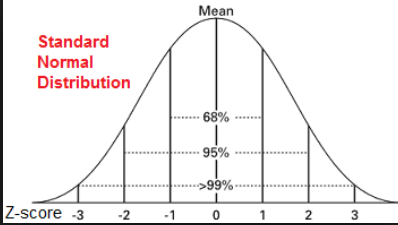

The mean is the average of the observations – add them up and
divide by the count. That's going to be right in the middle of the curve
if you plot your observations.

The standard deviation is a little more complicated. It's a
measure of the "spread" of the data. A high standard deviation means a
wide distribution. A low standard means a more "peaked" one.

It's based on something called the variance (actually, the
standard deviation is just its square root). 

To get the variance,
you find the difference between each observation and the mean. Then
square each difference (this makes sure that each contribution is a
positive number that reflects how far off-center the observation is).
Then figure out the mean (average) of all the squared differences.

In 'mathy' parlance:

    Variance = [ SUM (observed - mean ) ^2 ] / number of observations

    Standard deviation = SQRT (Variance)

Back to rescaling ... you want to transform your observations so that it
looks as close to the ideal version as possible. 

To accomplish that you
make up a scaling factor based on the mean and standard deviation of the
entire data set then apply it to each element.

This involves subtracting the mean (that centers the distribution) and
dividing by the standard deviation (this controls the "spread").

Here's a simple example, starting with a weird distribution called the
Gumbel distribution.

https://en.wikipedia.org/wiki/Gumbel_distribution

... which yields this probability density function (PDF). You can see that its "center of
mass" is right over the zero mark on the x-axis and that the right tail
has been pulled in a bit.

In [ ]:
np.random.seed(1)
bins = 100
data = np.random.gumbel(size=2000) * 2 - 4
original_ser = pd.Series(data)
original_ser.hist(bins=bins)

As an aside, the np.random library supports dozens of distributrions.

The docs provide links to technical descriptions of all of them.   A great weekend read ;-):
https://numpy.org/doc/1.16/reference/routines.random.html

|		|		|			|
|-----------------|----------------------|-----------------------|
|		|		|			|
|	beta	|	lognormal	|	standard_cauchy		|
|	binomial	|	logseries	|	standard_exponential		|
|	chisquare	|	multinomial	|	standard_gamma		|
|	dirichlet	|	multivariate_normal	|	standard_normal		|
|	exponential	|	negative_binomial	|	standard_t		|
|	f	|	noncentral_chisquare	|	triangular		|
|	gamma	|	noncentral_f	|	uniform		|
|	geometric	|	normal	|	vonmises		|
|	gumbel	|	pareto	|	wald		|
|	hypergeometric	|	poisson	|	weibull		|
|	laplace	|	power	|	zipf		|
|	logistic	|	rayleigh	|	 		|



Back to transforming distributions...

Here's how to normalize a distribution:

In [ ]:
# The mean() and std() functions are methods of the Series object
mean = original_ser.mean()
stdev = original_ser.std()

# Center the distribution at 0 (the 't-mean' bit) then denominate by the standard deviation
norm = (original_ser - mean) / stdev
norm.hist(bins=100)

In [ ]:
print(f"The mean is now {norm.mean():3f} with a StdDev of {norm.std():3f}")


One nice thing about this transformed distribution is that we can use
the x-axis to determine cutoff points (in terms of the standard
deviation) that enclose particular fractions of the distribution. 

If we
look at the idealized distribution above, we can see that the 99% of all
observations are within 3 standard deviations of the mean; 95% are
within 2 standard deviations; and two-thirds are within one standard
deviation.

This makes it easy to use a rule-based approach to throwing out
potentially-aberrant observations. So, for instance, we might want to
get rid of everything that's more than 2 standard deviations from the
mean – getting rid of 5% of the data in an ideal world .

Here's one way to approach the problem:

In [ ]:
test = pd.Series([1, 2, 3, 4, 5])

# Use a logical test to identify good values, creating a new object.
bmask = test[test >= 3]

# The index of the new object has valid index points
bmask.index

We can "borrow" the new object's index and use it to select elements of the original:

In [ ]:
test[bmask.index]

This example is a bit silly because the solution is obvious, but it's a general technique that can come in handy:

- do any number of transformations on original data


- create a mask against the transformed version


- apply the mask back to the original data

Now, let's chop off any data that's more than two standard deviations from the mean:

In [ ]:
# Find values mean +/- 2 standard deviations
bmask = norm[(norm > -2) & (norm < 2)]
clean = norm[bmask.index]

Here, we'll do a quick-and-dirty plot to check out our results:

In [ ]:
import scipy.stats as stats

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

ax = axes[0]
ax.set_title("original")
original_ser.hist(bins=bins, ax=ax)

ax = axes[1]
ax.set_title("normalized")
norm.hist(bins=bins, ax=ax)

ax = axes[2]
ax.set_title("clean")
clean.hist(bins=bins, ax=ax)

We can apply the same index against the original values. The visual
effect is less dramatic, but we've chopped off the highest values so
instead of the x-axis going to around 7 it now stops at about 3.

These are just a couple fairly straightforward data cleaning methods.
Naturally, things can get more complicated. 

For instance, if you're
interested in filtering signals (noise reduction, etc.) you might check
out the **signal** library at:

https://docs.scipy.org/doc/scipy-0.18.1/reference/signal.html. 

If you're interested in image processing
(cancelling out "green screen" effects, etc.) you might investigate:

    - pillow/PIL https://python-pillow.org/
    
    - ndimagey https://docs.scipy.org/doc/scipy/reference/ndimage.html\#module-scipy.ndimage
    
    - scikit-image https://scikit-image.org. 

Unfortunately, these are beyond the scope of the
present class.

Slicing, Dicing and Re-indexing
-------------------------------

As you've seen already, NumPy and pandas objects work a lot like
**list** objects. They carry indices along with them and can be
addressed via slicing operations. 

They also work a lot like **dict**
objects where values/components can be addressed by named key values.
You've also seen that these objects have separate index and value
components and that the index can be "borrowed" from one object and
applied to another. 

This section will take a further look at how all
this works and how you can apply it to your advantage. 

For simplicity of
exposition we'll focus on the **Series** object, but the concepts are
easily applied to other objects like the **DataFrame** and **Panel** –
and most to NumPy **ndarrays** upon which these are built.

### Index Objects

Unlike a **list** object, pandas index objects are largely under the
control of the user. This is evident as we apply the **Series** object's
constructor:

In [ ]:
duck_index = ["duck0", "duck5", "duck10"]
data = (0, 5, 10)
s = pd.Series(data=data, index=duck_index)
s

We can play around with this, accessing elements in a variety of ways as
we get our ducks in a row : -)

In [ ]:
s["duck0":"duck5"]

Note: the Pandas' name-based slicing works a bit differently than index-based slicing.  With name-based slices, the operation returns an object **inclusive** of the last element.   You can see we got "duck5" as the last element.

Slicing a list, like duck_index excludes the last element:

In [ ]:
dlist = duck_index
dlist[0:1]

The indices and values are essentially stored separately, and can be
addressed accordingly.   Pandas lets us "bolt on" additional indices.

Note from the output below that the **Index** is
a different object than the array:

In [ ]:
s.values

In [ ]:
s.index

We can, if we want create a new **Index** object from its constructor
and apply it to our array. 

Here's an example:

In [ ]:
quacker_index = pd.Index(['qucker1', 'quacker2', 'quacker3'], dtype='object')
s.index = quacker_index
s

### Re-Indexing

The fact that the index and values are separate is really powerful
because it allows rearranging data along new indices as they are
provided. 

Consider this example:

In [ ]:
s.index = duck_index
print(f"Ducks:\n\n{s}\n")

newix = ["duck0", "duck1", "duck2", "duck5", "duck10"]
s = s.reindex(newix)
print(f"Reindexed: \n\n{s}")

By inspection, you can observe that the existing values associated with
the original indices for "duck0, duck5, and duck10" all persisted.


Placeholders were created for the newly-added index points. We didn't
even have to create a separate **Index** object – pandas was smart
enough to know we needed one (it'll actually work with anything that
looks like it will fit – a **tuple**, **array**, etc.)


If we want, we can ask to fill in the placeholders as the index is
expanded using the methods **bfill**(), **ffill**(), and **nearest**().


In [ ]:
s = s.ffill()

It's also possible to sort a **Series** using by **sort\_index**() and
**sort\_values**(). 

Be careful, though, as the results may not be what
you expect:

In [ ]:
s.sort_index()

In [ ]:
s.sort_values()

Data Description / Analysis Tools
---------------------------------

Pandas has a pretty good set of data introspection tools baked right
into the objects. We'll go over these in more detail as we analyze real
data, but here's an overview.

Working still with the Gumbel distribution, we'll make a two-column
**DataFrame** object by providing a **dict** to the constructor:

It's possible to use the **DataFrame**'s built-in **describe**() method
to get some basic statistics (these will also work on the **Series**
object):

In [ ]:
import numpy as np
import pandas as pd

data = np.random.gumbel(size=1000)
df = pd.DataFrame({'a': data, 'b': data*2})
df

The **describe**() method works like most of the others. It actually
returns a new **ndarray** object that we can selectively query. 

Typically, all the Pandas methods return either a pandas.Series or a pandas.DataFrame object.   The most notable exception is when a single value is returned.

In [ ]:
d = df.describe()
d

For
instance, if we just wanted the mean from the first column we could go:

In [ ]:
d['a']['mean']

We can, alternatively, directly query this information using methods
like **mean**(), **min**(), **std**(), **kurtosis**(), and **max**().

Here are a few examples. Note that you have a choice of syntax when
accessing them.

In [ ]:
df.mean()

In [ ]:
df.mean()['a']

In [ ]:
df['a'].mean()

We can whistle up some tests quickly. 

Here's a test for normality run
against the first column of data:

In [ ]:
sn = stats.normaltest(df['a'])
print(sn)

In [ ]:
# For most of these tests, we can run them like this:
test_stat, pvalue = stats.normaltest(df['a'])

print(f"The test of normalicy has a p-value of {pvalue:.3f}")

We can go ahead and pick off the components. 

The 'statistic' is the
combined z-score for tests of skewness and kurtosis. That's very roughly
the number of standard deviations away from what we'd expect if the
distribution was perfectly normal – a small number is better than a
larger one.

The **'pvalue'** is what we're really after. 

The **pvalue** provides an
estimate of how much confidence we can have about rejecting the null
hypothesis (that the distribution is normal). 

In this case the null
hypothesis is that the distribution is normal and smaller the p-value,
the more certain we are that the distribution doesn't fit the normal
distribution. 

At p=.05, we'd be 95% certain that we can reject...

... and with a value this low there's about zero percent chance that
we've made a bad call. Another way to get at the same question is to ask
whether, based on the skewness of our data, whether it probably came
from a normally-distributed population.

Some of the other tests available include **binom\_test** (tests if
binomally distributed) and **ttest\_ind** (tests two samples to figure
out whether they probably came from the same population by comparing
their means).

Here is how to use **ttest\_ind**(). It takes two array-like objects and
is pretty flexible in just what they are – **ndarrays**, **Series**, and
even humble **list** objects all work equally well.

In [ ]:
test_stat, pvalue = stats.ttest_ind(df['a'], df['b'])
print(f"The t-test for independent means yields a p-value of {pvalue:.3f}")

But we should really not be cavalier about this.   Nothing about Python's data science stack is 'hand-holdy'.   Sure, we've got a result, but is it any good?   Is it garbage?   To Python, we've handed off a couple of arrays and it handed off some numbers.

Unless you KNOW what a t-test for independent means is, and a lot of other things about it, you don't want to share your results or any conclusions you draw.

Here, you might google something like "t-test for independent means assumptions".   You then may discover a web site like:

http://www.psychology.emory.edu/clinical/bliwise/Tutorials/TOM/meanstests/tind.htm

There you might learn that:

    - the null hypothesis is that populations means are equal
    
    - we assume that the sample means provide a reliable estimate of the population mean
    
    - we assume that the data represent interval or ratio scales
    
    - the populations are normally distributed
    
    - the populations have the same variance
         
    - the test assumes no overlap between the two groups these data represent
    
Digging deeper, you might discover that you can check variances with a Levene test:

In [ ]:
test_stat, pvalue = stats.levene(df['a'], df['b'])
print(f"The Levene test for equal variances yields a p-value of {pvalue:.3f}")

You get the idea.  The stats tests are a chainsaw in that they need to be used with care and respect.

Back to our example:

One can just "eyeball" this result to see that that the two columns of
our **DataFrame** are not from the same population.

The docstring will get you the gory details on how to compare
the means of two related samples. It'll show you how to manage treatment
of missing values, etc.   

That being said, the docstring will generally tell you more about the implementaton of a test than it will about the theory behind it.

In [ ]:
help(stats.ttest_ind)

## Exercise

rotowire.com publishes an excellent compendium of baseball statistics. Some of these are available in your course materials file directory as "baseball_stats.xls".   http://www.rotowire.com/baseball/player_ex_stats

Please practice some of your chops against this file.

- use the pandas read_excel() method to read columns "A" to "M" only.


- one of the columns, "bb_pct" shows the percentage of at-bats that resulted in walks. Create a histogram so you can examine it.


- find the mean and standard deviation then determine if this is probably normally distributed.


- prune the outliers (maybe get rid of zero values and those above 20%).


- create a standardized version of the pruned distribution then trim it so it contains only the data that's within one standard deviation of the mean. Use its index to create a pruned version of the original.



How does the mean and standard deviation of the this version compare to the original? Is it more or less likely to be normally-distributed?

Extra credit:

Create a bunch of new Series, based on subsets of the pruned version, with varying numbers of observations and determine whether each is likely to be normally-distributed (you need at least 20 for normaltest() to work, and should get at least 100 at the high end). You can use slice notation or perhaps the sample() method of the Series object here. Gather the results into a new Series and create a histogram.

What do you observe about the p-value as the number of observations grows?



Solution:  solution_baseball_hitting.ipynb